In [1]:
import keras 
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Reshape
from keras.layers import Convolution2D, MaxPooling2D, UpSampling2D
from keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
import itertools
import io
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
np.random.seed(420) 

In [3]:
def create_feedforward_network(model, hidden_sizes, input_shape=None):
    count = 0
    for size in hidden_sizes:
        if count == 0 and input_shape is not None:
            model.add(Dense(size, activation='relu', input_shape=input_shape))
            count+=1
        else:
            model.add(Dense(size, activation='relu'))

In [4]:
def create_convolutional_network(model, conv_sizes, fc_sizes, input_shape):
    #structure: conv, pool, conv, pool and so on 
    count = 0
    for size in conv_sizes:    
        num_filters, kernel_size, pool_size = size
        if count == 0:
            model.add(Convolution2D(num_filters, kernel_size=(kernel_size, kernel_size), padding='same', activation='relu', input_shape=input_shape))
            count+=1
        else:
            model.add(Convolution2D(num_filters, kernel_size=(kernel_size, kernel_size), padding='same', activation='relu'))
        model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))
    model.add(Flatten())
    create_feedforward_network(model, fc_sizes)

In [5]:
def create_network(hidden_sizes, num_outputs, do_regression, use_fc=True, conv_sizes=None, input_shape=None, optimizer='adam'):
    model = Sequential()
    if use_fc:
        create_feedforward_network(model, hidden_sizes, input_shape)
    else:
        create_convolutional_network(model, conv_sizes, hidden_sizes, input_shape)
    if do_regression:
        model.add(Dense(num_outputs))
        model.compile(loss='mean_squared_error', optimizer=optimizer)
    else:
        model.add(Dense(num_outputs, activation='softmax'))
        model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

    return model


In [6]:
def get_fc_data():
    ''' 
    assume data is of the form:
    each row of X is [x1, x2, a, b] where c = a+bi and x1, x2 are the mapped point 
    Y is a vector with 0/1 values that represent if that particular pixel location + c-value diverge or not
    '''
    X = np.load('X.npy')
    Y = np.load('Y.npy')
    Y = to_categorical(Y)
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)
    return X_train, X_test, y_train, y_test


In [7]:
def subSample(anArray, reductionFactor,shouldDraw=False):
    #Note that reductionFactor is a float between 0 and 1
    #Also note reductionFactor is per dimension (so for us, the true size reduction is
    #   reductionFactor squared)
    xSamples = np.linspace(0,255,int(255*reductionFactor),dtype=int)
    ySamples = np.linspace(0,383,int(383*reductionFactor),dtype=int)
    ans = anArray[np.ix_(xSamples, ySamples)]
    if shouldDraw:
        plt.figure()
        plt.imshow(ans, cmap="gray")
        plt.figure()
        plt.imshow(anArray, cmap="gray")
    return ans

In [109]:
def get_conv_data():
    Y = np.load('C_values.npy')#batch size by 2 matrix
    reduction_factor = 1
    img_shape = [int(256*reduction_factor), int(384*reduction_factor)]
    X = np.zeros((Y.shape[0], *img_shape))#images
    base = 'data/julia'
    for i in range(Y.shape[0]):
        img = np.load(base+str(i)+'.npy')
#         img = subSample(img, reduction_factor)
        X[i] = img
    X = np.reshape(X, (*X.shape, 1))
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)
    return X_train, X_test, y_train, y_test, img_shape

In [110]:
def cross_val(model, X, y, num_folds, classification=False, fit_params=dict()):
    if classification:
        kfold = StratifiedKFold(n_splits=num_folds, random_state=None, shuffle=True)
        scorer = accuracy_score
    else:
        kfold = KFold(n_splits=num_folds, random_state=None, shuffle=True)
        scorer = mean_squared_error
    return cross_val_score(model, X, y, cv=kfold, scoring=make_scorer(scorer), fit_params=fit_params)

In [111]:
def f(z, c):   #iterating function
    return z * z + c
def does_diverge(z, c, iters):  #checks if a given pixel diverges
#     iters = 3
    for _ in range(iters):
        z = f(z, c)
        if abs(z) > 2: # Diverges
            return 1
    return 0
def generate_julia_set(size, c=False, iterations=50):
    x = np.linspace(-2, 2, size * 3)
    y = np.linspace(-1, 1, size * 2)
    X = np.array(list(itertools.product(y, x)))[:, (1, 0)]
    if not c:
        output = np.array([does_diverge(complex(*sample), complex(*sample), iterations) for sample in X])
    else:
        output = np.array([does_diverge(complex(*sample), c, iterations) for sample in X])
    return X, output.reshape((size * 2, size * 3)) #image format

In [112]:
Xtrain_fc, Xtest_fc, ytrain_fc, ytest_fc = get_fc_data()

In [113]:
# fc_architectures = [[128, 64, 32], [512, 256, 128, 64, 32], [1024, 512, 256, 128, 64, 32]]
# histories = []
# batch_size = 2048
# num_epochs = 100
# for architecture in fc_architectures:
#     fc_model = create_network(architecture, 2, False, input_shape=[4])
#     hist = fc_model.fit(Xtrain_fc, ytrain_fc, batch_size=batch_size, shuffle=True, steps_per_epoch=None, epochs=num_epochs, validation_split=.33)
#     histories.append(hist)

In [114]:
Xtrain_conv, Xtest_conv, ytrain_conv, ytest_conv, input_shape = get_conv_data()

In [115]:
conv_architectures = [
#     [[64, 3, 2], [64, 3, 2], [64, 3, 2]],
    [[16, 3, 1], [32, 3, 2], [64, 3, 2], [64, 3, 2]],
]
fc_architectures = [ 
    [256, 128, 64, 32, 16]
]
y_scaling = 10

In [24]:
batch_size = 16
num_epochs = 20
for conv_architecture in conv_architectures:
    for fc_architecture in fc_architectures:
        model = create_network(fc_architecture, 2, True, conv_sizes = conv_architecture, use_fc=False, input_shape=[*input_shape, 1])
        hist = model.fit(Xtrain_conv, ytrain_conv*y_scaling, batch_size=batch_size, shuffle=True, steps_per_epoch=None, epochs=num_epochs, validation_split=.33)
        print(model.evaluate(Xtest_conv, ytest_conv*y_scaling))

Train on 965 samples, validate on 476 samples
Epoch 1/20
965/965 [==============================] - 10s 11ms/step - loss: 4.7288 - val_loss: 0.4463
Epoch 2/20
965/965 [==============================] - 8s 8ms/step - loss: 0.2307 - val_loss: 0.1353
Epoch 3/20
965/965 [==============================] - 8s 8ms/step - loss: 0.0739 - val_loss: 0.1736
Epoch 4/20
965/965 [==============================] - 8s 8ms/step - loss: 0.0541 - val_loss: 0.0913
Epoch 5/20
965/965 [==============================] - 8s 8ms/step - loss: 0.0351 - val_loss: 0.0446
Epoch 6/20
965/965 [==============================] - 8s 8ms/step - loss: 0.0337 - val_loss: 0.0260
Epoch 7/20
965/965 [==============================] - 8s 8ms/step - loss: 0.0318 - val_loss: 0.0160
Epoch 8/20
965/965 [==============================] - 8s 8ms/step - loss: 0.0150 - val_loss: 0.0467
Epoch 9/20
965/965 [==============================] - 8s 8ms/step - loss: 0.0908 - val_loss: 0.1919
Epoch 10/20
965/965 [==============================]

NameError: name 'histories' is not defined

In [25]:
print(model.evaluate(Xtest_conv, ytest_conv*y_scaling))

711/711 [==============================] - 2s 2ms/step
0.0332142010871


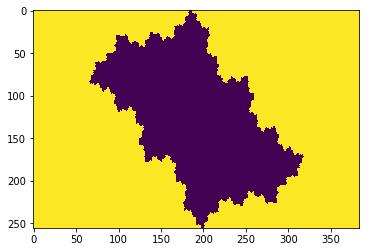

In [26]:
example = 20
pred = model.predict(np.reshape(Xtest_conv[example], (1, *Xtest_conv[48].shape)))[0]/y_scaling
x, output_shape = generate_julia_set(128, pred[0] + pred[1]*1j)
plt.imshow(output_shape)

In [ ]:
c = ytest_conv[example]
x, output_shape = generate_julia_set(128, c[0] + c[1]*1j)
plt.imshow(output_shape)

In [116]:
del model #to save your gpu memory :) 

In [117]:
def autoencoder(conv_sizes, input_shape, hidden_sizes=[], latent_size=2, optimizer='adam'):
    model = Sequential()
    image_shape, extra_fc = down_conv(model, conv_sizes, input_shape, hidden_sizes, latent_size)
    conv_sizes.reverse()
    hidden_sizes.reverse()
    up_conv(model, conv_sizes, hidden_sizes, latent_size, image_shape, extra_fc)
    model.compile(loss='mean_squared_error', optimizer = optimizer)
    return model

In [118]:
def down_conv(model, conv_sizes, input_shape, hidden_sizes, latent_size):
    count = 0
    for size in conv_sizes:    
        num_filters, kernel_size, pool_size = size
        if count == 0:
            model.add(Convolution2D(num_filters, kernel_size=(kernel_size, kernel_size), padding='same', activation='relu', input_shape=input_shape))
            count+=1
        else:
            model.add(Convolution2D(num_filters, kernel_size=(kernel_size, kernel_size), padding='same', activation='relu'))
        model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))
    image_shape = model.output_shape
    model.add(Flatten())
    extra_fc = model.output_shape
    create_feedforward_network(model, hidden_sizes)
    model.add(Dense(latent_size, activation='relu')) #here add penalty to make similar to c 
    return image_shape[1:], extra_fc[1:][0]

In [119]:
def up_conv(model, conv_sizes, hidden_sizes, latent_size, image_shape, extra_fc):
    hidden_sizes = [latent_size] + hidden_sizes + [extra_fc]
    create_feedforward_network(model, hidden_sizes)
    model.add(Reshape(image_shape))  
    count = 0
    for size in conv_sizes:
        #architecture: conv pool 
        num_filters, kernel_size, up_size = size
        model.add(UpSampling2D(size=(up_size, up_size)))
        model.add(Convolution2D(num_filters, kernel_size=(kernel_size, kernel_size), padding='same', activation='relu'))
        count+=1
    model.add(Convolution2D(1, kernel_size=(3, 3), padding='same', activation='relu'))
    print(model.output_shape)

In [120]:
# convert auto encoder output to fractal
# test_img = None
# autoencoder = None
# test_output = autoencoder.predict(test_img)
# test_output = np.where(test_output>=.5, 1, 0)
# plt.imshow(test_output, cmap='grey')

In [186]:
conv_sizes = [[16, 3, 2], [32, 3, 2], [64, 3, 2], [64, 3, 2]]
model = autoencoder(conv_sizes, [*input_shape, 1], latent_size=2)

(None, 256, 384, 16)
(None, 128, 192, 32)
(None, 64, 96, 64)
(None, 32, 48, 64)
(None, 16, 24, 64)
(None, 16, 24, 64)
(None, 32, 48, 64)
(None, 64, 96, 64)
(None, 128, 192, 32)
(None, 256, 384, 16)
(None, 256, 384, 1)


In [187]:
batch_size=16
num_epochs = 20

In [188]:
model.fit(Xtrain_conv, Xtrain_conv, batch_size=batch_size, shuffle=True, steps_per_epoch=None, epochs=num_epochs, validation_split=.33)

Train on 965 samples, validate on 476 samples
Epoch 1/20
965/965 [==============================] - 11s 12ms/step - loss: 0.1672 - val_loss: 0.1012
Epoch 2/20
965/965 [==============================] - 10s 11ms/step - loss: 0.0993 - val_loss: 0.0985
Epoch 3/20
965/965 [==============================] - 10s 11ms/step - loss: 0.0976 - val_loss: 0.0963
Epoch 4/20
965/965 [==============================] - 11s 11ms/step - loss: 0.0929 - val_loss: 0.0877
Epoch 5/20
965/965 [==============================] - 11s 11ms/step - loss: 0.0751 - val_loss: 0.0696
Epoch 6/20
965/965 [==============================] - 11s 11ms/step - loss: 0.0701 - val_loss: 0.0697
Epoch 7/20
965/965 [==============================] - 11s 11ms/step - loss: 0.0671 - val_loss: 0.0669
Epoch 8/20
965/965 [==============================] - 11s 11ms/step - loss: 0.0663 - val_loss: 0.0655
Epoch 9/20
965/965 [==============================] - 11s 11ms/step - loss: 0.0656 - val_loss: 0.0642
Epoch 10/20
965/965 [===============

In [189]:
model.evaluate(Xtest_conv, Xtest_conv)

711/711 [==============================] - 2s 3ms/step


0.059264517267419319

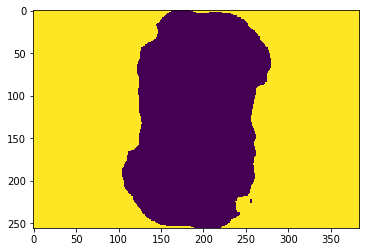

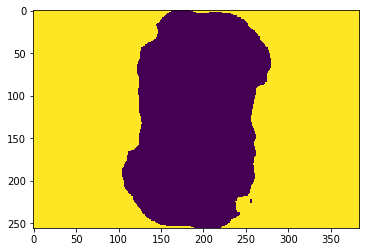

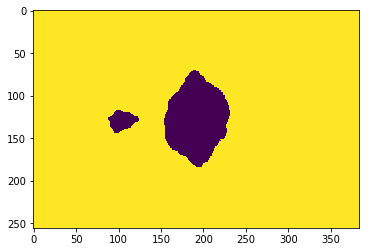

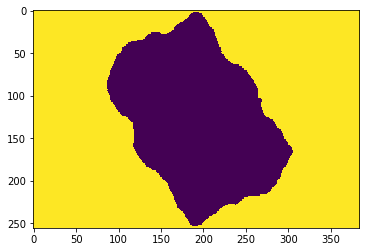

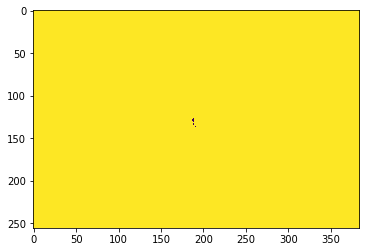

In [190]:
# convert auto encoder output to fractal
for example in range(5):
    test_img = Xtrain_conv[example]
    test_output = model.predict(np.reshape(test_img, (1, *test_img.shape)))
    test_output = np.where(test_output>=.5, 1, 0)[0]
    test_output = np.reshape(test_output, (256, 384))
    plt.figure()
    plt.imshow(test_output)

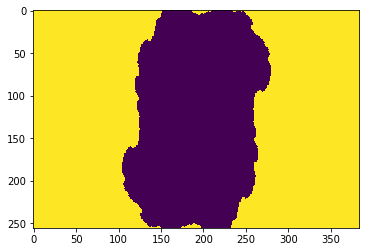

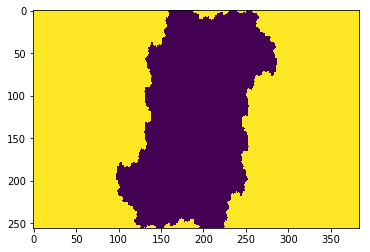

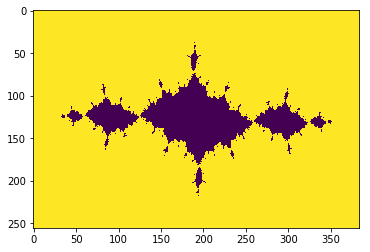

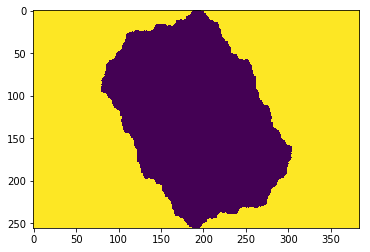

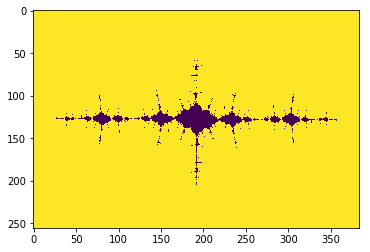

In [191]:
for example in range(5):
    test_output = np.reshape(Xtrain_conv[example], (256, 384))
    plt.figure()
    plt.imshow(test_output)

In [ ]:
#visualize encoder results/plots
# add penalty to latent layer
# deeper nets :D
#add stuff to paper 